In [1]:
# libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import pickle

from IPython.display import display
from numpy import where
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.svm import OneClassSVM
import operator

In [2]:
# Constants
TRAINING_YEAR = 2015
TESTING_YEAR = 2017
ATTRIBUTE_SIZE = 6

In [3]:
# We might not need player_data.csv and players.csv since they are personal information that we can not make use of
salary_20 = pd.read_csv("salary_0020.csv")
salary_17 = pd.read_csv("salary_1718.csv")
stats = pd.read_csv("1950/seasons_stats.csv")
stats = stats.drop(stats.columns[0], axis=1)
pd.set_option('display.max_columns', None)


# Append salary to the dataframe
# Use the following attributes to fit models
# age, G, GS, MP, PER, TS, FTr, ORB%, DRB%, TRB%, AST%  STL%  BLK% TOV%  USG%, OWS  DWS, WS  WS/48, VORP, OBPM  DBPM  BPM and everything afterwards

team_names = {
    "Atlanta Hawks":"ATL",
    "Boston Celtics":"BOS",
    "Brooklyn Nets":"BKN",
    "Charlotte Hornets":"CHA",
    "Charlotte Bobcats":"CHB",
    "Chicago Bulls":"CHI",
    "Cleveland Cavaliers":"CLE",
    "Dallas Mavericks":"DAL",
    "Denver Nuggets":"DEN",
    "Detroit Pistons":"DET",
    "Golden State Warriors":"GSW",
    "Houston Rockets":"HOU",
    "Indiana Pacers":"IND",
    "LA Clippers":"LAC",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers":"LAL",
    "Memphis Grizzlies":"MEM",
    "Miami Heat":"MIA",
    "Milwaukee Bucks":"MIL",
    "Minnesota Timberwolves":"MIN",
    "New Orleans Pelicans":"NOP",
    "New York Knicks":"NYK",
    "Oklahoma City Thunder":"OKC",
    "Orlando Magic":"ORL",
    "Philadelphia 76ers":"PHI",
    "Phoenix Suns":"PHX",
    "Portland Trail Blazers":"POR",
    "Sacramento Kings":"SAC",
    "San Antonio Spurs":"SAS",
    "Toronto Raptors":"TOR",
    "Utah Jazz":"UTA",
    "Washington Wizards":"WAS",
    "Seattle SuperSonics":"SEA",
    "Vancouver Grizzlies":"VAN",
    "New Jersey Nets":"NJN",
    "New Orleans Hornets":"NOK",
}

unknowns = [
    'Madrid Real Madrid',
    "null Unknown",
    "NO/Oklahoma City Hornets",
    'Bilbao Basket Bilbao Basket',
    "Fenerbahce Ulker Fenerbahce Ulker",
    "Maccabi Haifa Maccabi Haifa"
]

# Convert team names in 0020 dataset to abbreviations
for i in range(len(salary_20)):
    v = salary_20['team'][i]
    if v in unknowns:
        continue
    salary_20.loc[i,'team'] = team_names[v]

# Remove unknowns
for v in unknowns:
    salary_20 = salary_20[salary_20['team'] != v]

# Only use players from 2000 onward
stats = stats[stats['Year'] >= 2000]


# Add salary to stats dataset based on player, year
merged_00_to_17 = stats.merge(salary_20, left_on=['Year', 'Player', 'Tm'], right_on=['season', 'name', 'team'])

# Drop unused columns that we think are irrelevant from merged dataset
merged_00_to_17 = merged_00_to_17.drop(columns = ['Player', 'Pos', 'Tm', '3PAr', 'blanl', 'blank2', 'rank', 'position', 'team', 'name', 'season'])

# Replace Nan with 0
merged_00_to_17.fillna(0, inplace=True)

# display(salary_20.head(10))

# display(stats.head(10))

# display(merged_00_to_17.head(10))

# display(merged_00_to_17.tail(10))

# Different datasets to see what produces best predictions
# Can either always predict later year or split train, test throughout years

merged_10_to_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2010]

merged_13_to_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2013]

# Using 16 to predict 17

merged_16_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2016]

# Split within year

merged_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2017]

Visualize correlation using Heatmap

<Axes: >

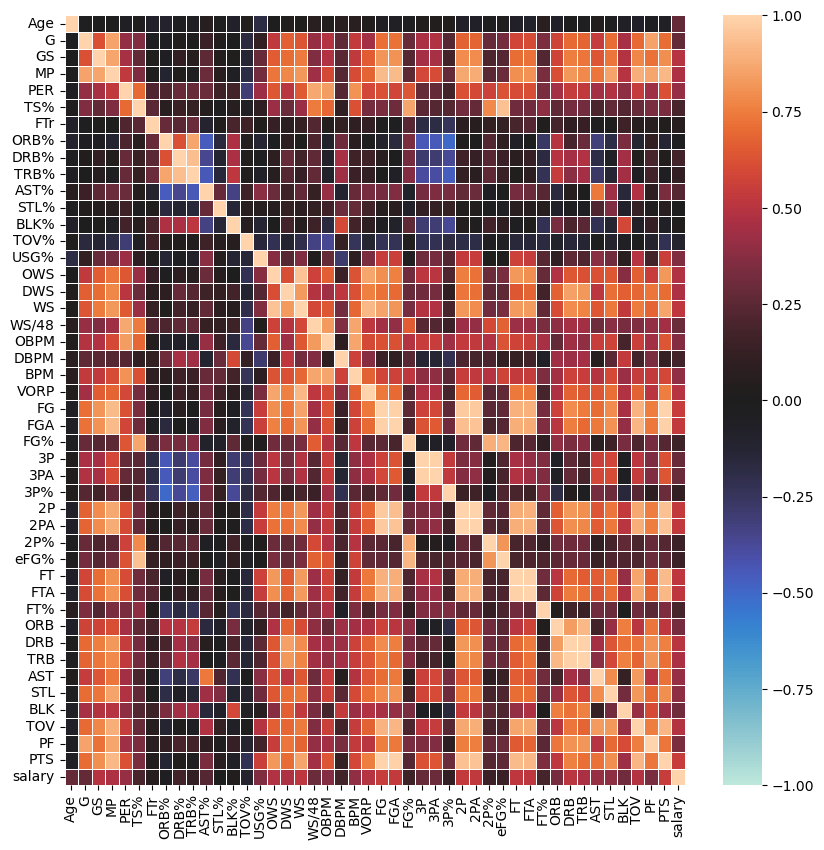

In [4]:
# heatmap for correlation
fig, ax = plt.subplots(figsize=(10, 10))

sb.heatmap(merged_00_to_17.drop(['Year'], axis = 1).corr(), vmin=-1, vmax=1, center= 0, linewidths=.5, xticklabels=True, yticklabels=True)

Pairplot with MP

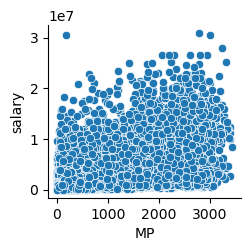

In [5]:
sb.pairplot(merged_00_to_17, x_vars = ["MP"], y_vars = ['salary'])
plt.show()

In [6]:
# Filter the most relevant attributes
filtered_0017 =  merged_00_to_17.drop(['Year'], axis=1)

# Only need the salary column, and take out the correlation with salary itself
correlation = abs(filtered_0017.corr()['salary'][:-1])

# Get the sorted index of correlation
attribute_rank = np.argsort(correlation)

# Get the most relevant attributes
relevant_attributes = attribute_rank.index[attribute_rank[-ATTRIBUTE_SIZE:]]
print(relevant_attributes)

Index(['WS', '2PA', 'FGA', '2P', 'PTS', 'FG'], dtype='object')


In [7]:
# Filter out some outliers in order to make better predictions
#data = merged_00_to_17[merged_00_to_17['Year'] == TRAINING_YEAR]
#data = data.drop(['Year'], axis=1)

# Max is usually calculated by Q3 + 1.5 * IQR, where IQR = Q3 - Q1
#q3, q1 = np.quantile(data['salary'], [0.75, 0.25])
#local_max = q3 + 1.5 * (q3 - q1)

#data = data.reset_index(drop=True)
#sb.boxplot(data['salary'])
#print(local_max)

# Get rid of outliers
#data = data[data['salary'] <= local_max]

In [8]:
df_salary = merged_00_to_17.copy()

### Enable this line only for performance evaluation only because salaries are large numbers and doing so would produce 
# smaller rmse and variance
# df_salary['salary'] = df_salary['salary'] / 1e6
###

salary_train, salary_test = train_test_split(df_salary, test_size=0.2)
X_salary_train, y_salary_train = salary_train[relevant_attributes], salary_train['salary']
X_salary_test, y_salary_test = salary_test[relevant_attributes], salary_test['salary']
# print(X_salary_train)
# print(y_salary_train)

In [9]:
# Scale the data, but keep the original salary because we need to get the actual prediction
scaler = StandardScaler()
scaler.fit(X_salary_train)

Z_salary_train = scaler.transform(X_salary_train)
Z_salary_test = scaler.transform(X_salary_test)


Degree: 1
Training RMSE: 3751209.856639629
Testing RMSE: 4206955.422434642
Variance: 3626898537801.9316
Training R2: -1.1318679760138113
Testing R2: -1.514458312297962


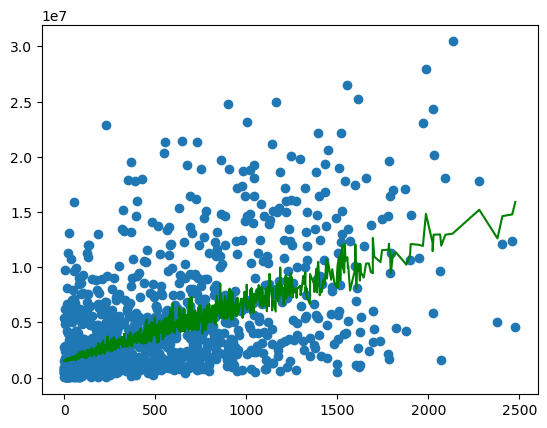


Degree: 2
Training RMSE: 3713469.362000928
Testing RMSE: 4130021.885744506
Variance: 3267226074209.0293
Training R2: -1.0036679135901192
Testing R2: -1.3653649087932105


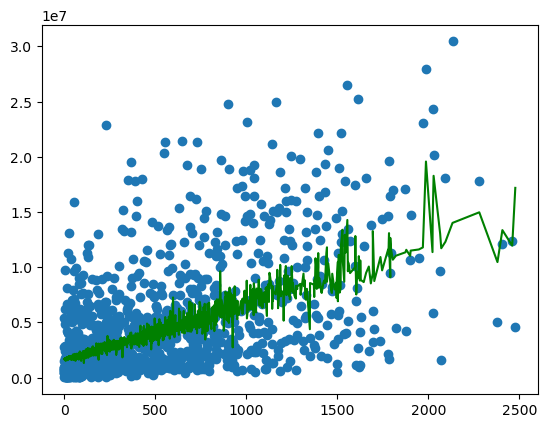


Degree: 3
Training RMSE: 3668176.251532989
Testing RMSE: 4157526.108423
Variance: 3829506329908.287
Training R2: -0.8645118869077935
Testing R2: -1.0726557131768009


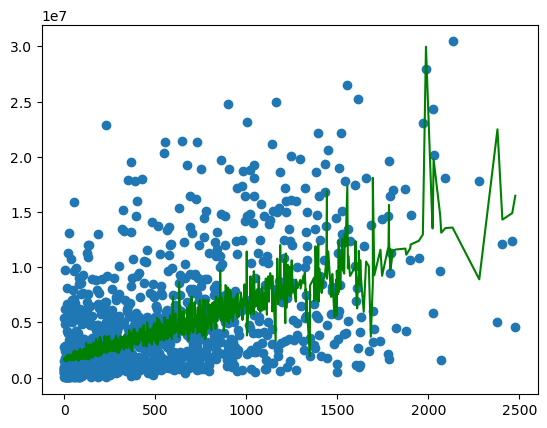


Degree: 4
Training RMSE: 3559949.7285414403
Testing RMSE: 4698234.675432205
Variance: 9400166995691.281
Training R2: -0.5843695184700692
Testing R2: -0.7407623342781191


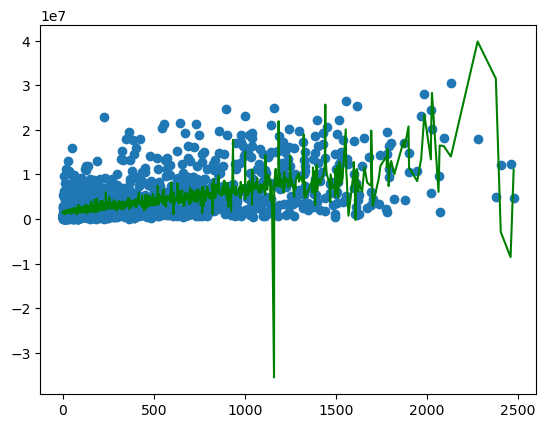

In [10]:
# polynomial regression model to predict salary based on PTS, FTA, 2PA, FGA, WS, GS 
# which were found to have some correlation to salary via heatmap

for i in range(1,5):
    poly = PolynomialFeatures(degree = i, include_bias = False)
    
    x_poly_train = poly.fit_transform(Z_salary_train)
    x_poly_test = poly.fit_transform(Z_salary_test)
    
    plr = LinearRegression().fit(x_poly_train, y_salary_train)

    train_poly_pred = plr.predict(x_poly_train)
    test_poly_pred = plr.predict(x_poly_test)

    mse_train = mean_squared_error(train_poly_pred, y_salary_train)
    mse_test = mean_squared_error(test_poly_pred, y_salary_test)
    print("\nDegree:", i)
    print("Training RMSE:", math.sqrt(mse_train))
    print("Testing RMSE:", math.sqrt(mse_test))
    print("Variance:", abs(mse_train - mse_test))
    print("Training R2:", r2_score(train_poly_pred, y_salary_train))
    print("Testing R2:", r2_score(test_poly_pred, y_salary_test))

    i = "PTS"
    x_pd = pd.Series(X_salary_test[i].values.flatten())
    y_pred_pd = pd.Series(test_poly_pred.flatten())

    x_sorted = x_pd.sort_values()

    Y_pred = np.array(y_pred_pd[x_sorted.index])
    x_arr = np.array(x_sorted)

    #plotting
    plt.scatter(X_salary_test[i], y_salary_test)
    plt.plot(x_arr, Y_pred, color='g')
    plt.show()

## Code for front-end

In [11]:
# Store scaler and linear model locally for front-end
pickle.dump(scaler, open('scaler', 'wb'))


model = PolynomialFeatures(degree = 1, include_bias = False)

x_poly_train = model.fit_transform(Z_salary_train)
x_poly_test = model.fit_transform(Z_salary_test)

model = LinearRegression().fit(x_poly_train, y_salary_train)

pickle.dump(model, open('model', 'wb'))